# 以相似度为训练目标

## 生成训练数据，暂存于本地

In [0]:
!git clone https://github.com/daibiaoxuwu/05wan3

In [0]:
!git clone https://github.com/daibiaoxuwu/05wan3b

In [0]:
import os
import cv2
import numpy as np
import random
path1 = '05wan3'
path2 = '05wan3b/0'

clocks = dict()
x_train0 = []
y_train0 = []
for filename in os.listdir(path2):
    if 'git' in filename: continue
    #print(path1)
    #ftimestr,number = path1.split('_')
    clocks[int(filename.split('_')[0])]=int(filename.split('_')[1][:-4])
    #clocks[int(ftimestr)]=int(number)
keys = clocks.keys()
filelist = os.listdir(path1)
random.shuffle(filelist)
for filename in filelist:
    if 'git' in filename or 'c.jpg' in filename: continue
    ftime = int(filename.split('_')[0])
    value = max(filter(lambda t:t<ftime,keys))
    x_train0.append(cv2.imread(os.path.join(path1,filename), cv2.IMREAD_GRAYSCALE)/255.0)
    y_train0.append(clocks[value])
    
print(len(x_train0),len(y_train0))

l = int(len(x_train0)*0.8)
x_train = x_train0[:l]
y_train = y_train0[:l]
x_test = x_train0[l:]
y_test = y_train0[l:]

# 数据初始化完成。
在读入图片时进行了shuffle。

# 装载Tensorflow

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# 安装 TensorFlow
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

# 输入数据生成器
# 变为5张图片一叠
对数据集和测试集分别进行操作。

In [0]:
idxes = []
for i in range(10):idxes.append([])
for idx, val in enumerate(y_train):
  idxes[val].append(idx)

idxes_test = []
for i in range(10):idxes_test.append([])
for idx, val in enumerate(y_test):
  idxes_test[val].append(idx) 

# 搭建训练数据

## 搭建训练数据generator

In [0]:
picnum = 5
import random
def train_generator():
  while True:
    dataout = []
    for i in range(5):dataout.append([])
    ansout = np.zeros((100,))
    for train2 in range(100):
      ans = random.randint(0,9)
      idx2 = random.sample(idxes[ans],5)
      
      #idx2 = idxes[ans][:5]
      for i in range(5):
        dataout[i].append(x_train[idx2[i]][:,:,np.newaxis])      
      ansout[train2] = ans
      #dataout.append(data)      
    yield [np.stack(data2) for data2 in dataout],ansout 


# 验证generator

In [0]:
tx,ty = next(train_generator())
print(tx[0].shape)
print(ty.shape)
import matplotlib.pyplot as plt
for i in range(5):
  plt.subplot(151+i)
          #plt.imshow(x_test[idx2[i]],cmap='gray')
  plt.imshow(tx[0][i][:,:,0])
  #plt.show()
  print(ty[i])


# 搭建模型和训练
现在的网络去掉dropout则可以拟合10张图片，
但是加上dropout就拟合不了。
从7张拟合5张的，则可以在两个epoch（每个epoch抽取60000次）内到80%。

继续训练20张，一个epoch就到60%。

In [0]:
picnum = 5
inputs = [tf.keras.layers.Input(shape=(12,12,1))  for i in range(picnum)]
#inputs = tf.keras.layers.Input(shape=(5,12,12,1))

conv_a1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
conva1 = [conv_a1(inputs[i]) for i in range(picnum)]
conv_b1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
convb1 = [conv_b1(conva1[i]) for i in range(picnum)]

conv_c1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
convc1 = [conv_c1(inputs[i]) for i in range(picnum)]
conv_d1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
convd1 = [conv_d1(convc1[i]) for i in range(picnum)]

convs1 = tf.stack(convb1)
convf1 = [
    tf.math.reduce_max(convs1, axis=[0]),
    tf.math.reduce_mean(convs1, axis=[0]),
    tf.math.reduce_min(convs1, axis=[0]),
]

conv_g1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
convg1 = [conv_g1(convf1[i]) for i in range(3)]

convh1 = [tf.concat(convg1+[convd1[i]],axis=3) for i in range(picnum)]
#------------------------------------------------------------------------------------------
conv_a2 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
conva2 = [conv_a2(convh1[i]) for i in range(picnum)]
conv_b2 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
convb2 = [conv_b2(conva2[i]) for i in range(picnum)]

conv_c2 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
convc2 = [conv_c2(inputs[i]) for i in range(picnum)]
conv_d2 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
convd2 = [conv_d2(convc2[i]) for i in range(picnum)]

convs2 = tf.stack(convb2)
convf2 = [
    tf.math.reduce_max(convs2, axis=[0]),
    tf.math.reduce_mean(convs2, axis=[0]),
    tf.math.reduce_min(convs2, axis=[0]),
]

conv_g2 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
convg2 = [conv_g2(convf2[i]) for i in range(3)]

convh2 = [tf.concat(convg2+[convd2[i]],axis=3) for i in range(picnum)]
#------------------------------------------------------------------------------------------
conv_a3 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
conva3 = [conv_a3(convh2[i]) for i in range(picnum)]
conv_b3 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
convb3 = [conv_b3(conva3[i]) for i in range(picnum)]

conv_c3 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
convc3 = [conv_c3(inputs[i]) for i in range(picnum)]
conv_d3 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
convd3 = [conv_d3(convc3[i]) for i in range(picnum)]

convs3 = tf.stack(convb3)
convf3 = [
    tf.math.reduce_max(convs3, axis=[0]),
    tf.math.reduce_mean(convs3, axis=[0]),
    tf.math.reduce_min(convs3, axis=[0]),
]

conv_g3 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
convg3 = [conv_g3(convf3[i]) for i in range(3)]

convh3 = tf.concat(convg3+convd3,axis=3)

convx1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')(convh3)
convx2 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')(convx1)
convx3 = tf.keras.layers.Flatten()(convx2)
convy1 = tf.keras.layers.Dense(256,activation='relu')(convx3)
#keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

#convy2 = tf.keras.layers.Dropout(0.2)(convy1)
convy3 = tf.keras.layers.Dense(10,activation='softmax')(convy1)

model = tf.keras.Model(inputs=inputs, outputs=convy3)

In [0]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
            
model.summary()

# 搭建测试用generator

In [0]:

def test_generator():
  while True:
    dataout = []
    for i in range(5):dataout.append([])
    ansout = np.zeros((100,))
    for train2 in range(100):
      ans = random.randint(0,9)
      idx2 = random.sample(idxes_test[ans],5)
      
      #idx2 = idxes[ans][:5]
      for i in range(5):
        dataout[i].append(x_test[idx2[i]][:,:,np.newaxis])      
      ansout[train2] = ans
      #dataout.append(data)      
    #print('ans:',ans)  
    yield [np.stack(data2) for data2 in dataout],ansout 

# 开始训练

In [0]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, mode='auto')
model.fit_generator(train_generator(),epochs=50,steps_per_epoch=300,validation_data=test_generator(),validation_steps=50,callbacks=[reduce_lr])

# 测试正确率

In [0]:

def eval_generator():
  for t in range(100):
    dataout = []
    for i in range(5):dataout.append([])
    ansout = np.zeros((100,))
    for train2 in range(100):
      ans = random.randint(0,9)
      idx2 = random.sample(idxes_test[ans],5)

      #idx2 = idxes[ans][:5]
      for i in range(5):
        dataout[i].append(x_test[idx2[i]][:,:,np.newaxis])      
      ansout[train2] = ans
      #dataout.append(data)      
    #print('ans:',ans)  
    yield [np.stack(data2) for data2 in dataout],ansout 
model.evaluate_generator(eval_generator())

# 找到识别失误的图像

[8526, 5037, 2888, 328, 5499]
ans: 2 pred: 3
[[5.3417426e-10 3.5618464e-09 4.2014951e-01 5.7984996e-01 7.7879792e-10
  4.4062321e-07 9.0269169e-16 1.2210177e-08 7.2447941e-14 4.6223991e-10]]


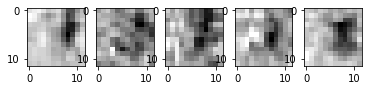

In [32]:

while True:
    dataout = []
    for i in range(5):dataout.append([])
   
    
    ans = random.randint(0,9)
    idx2 = random.sample(idxes_test[ans],5)
    
    #idx2 = idxes[ans][:5]
    for i in range(5):
      dataout[i].append(x_test[idx2[i]][:,:,np.newaxis])      
    
    #dataout.append(data)      
    try:
      data = [np.stack(data2) for data2 in dataout]
      predraw = model.predict(data,ans)
      pred = np.argmax(predraw)
      if(pred != ans):
        print(idx2)
        for i in range(5):
          plt.subplot(151+i)
          plt.imshow(x_test[idx2[i]],cmap='gray')
          dataout[i].append(x_test[idx2[i]][:,:,np.newaxis])  
        print('ans:',ans,'pred:',pred)
        print(predraw)
        break
    except ZeroDivisionError:pass
 